In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, CategoricalNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingClassifier
from sklearn.impute import SimpleImputer, KNNImputer

In [5]:
df = pd.read_csv('advertising_ef.csv')
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,City,Gender,Country,Clicked on Ad
0,68.95,35.0,61833.90,256.09,Wrightburgh,Female,Tunisia,0
1,NaN,31.0,68441.85,193.77,West Jodi,Male,Nauru,0
2,69.47,26.0,59785.94,236.50,Davidton,Female,San Marino,0
3,74.15,29.0,54806.18,245.89,West Terrifurt,Male,Italy,0
4,68.37,35.0,73889.99,225.58,South Manuel,Female,Iceland,0


In [7]:
df.columns

Index(['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage', 'City', 'Gender', 'Country', 'Clicked on Ad'],
      dtype='object')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1005 non-null   float64
 1   Age                       998 non-null    float64
 2   Area Income               998 non-null    float64
 3   Daily Internet Usage      1005 non-null   float64
 4   City                      998 non-null    object 
 5   Gender                    1009 non-null   object 
 6   Country                   996 non-null    object 
 7   Clicked on Ad             1009 non-null   int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 63.2+ KB


In [13]:
df.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Clicked on Ad
count,1005.000000,998.000000,998.000000,1005.000000,1009.000000
mean,65.009463,35.962926,54958.573617,180.041920,0.501487
std,15.879997,8.772142,13381.286752,43.923438,0.500246
min,32.600000,19.000000,13996.500000,104.780000,0.000000
25%,51.300000,29.000000,46993.367500,138.870000,0.000000
50%,68.370000,35.000000,56998.245000,183.420000,1.000000
75%,78.570000,42.000000,65267.402500,218.800000,1.000000
max,91.430000,61.000000,79484.800000,269.960000,1.000000


In [15]:
df.isnull().sum()

Daily Time Spent on Site     4
Age                         11
Area Income                 11
Daily Internet Usage         4
City                        11
Gender                       0
Country                     13
Clicked on Ad                0
dtype: int64

In [17]:
# Identify numerical and categorical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

In [19]:
# Handle missing values
num_imputer = KNNImputer(n_neighbors=3)
df[num_cols] = num_imputer.fit_transform(df[num_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

In [21]:
df.isnull().sum()

Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
City                        0
Gender                      0
Country                     0
Clicked on Ad               0
dtype: int64

In [23]:
cat_cols

['City', 'Gender', 'Country']

In [29]:
label_encoder = LabelEncoder()  # encoding categorical columns...

for features in cat_cols:
    df[features] = label_encoder.fit_transform(df[features])

In [31]:
num_cols

['Daily Time Spent on Site',
 'Age',
 'Area Income',
 'Daily Internet Usage',
 'Clicked on Ad']

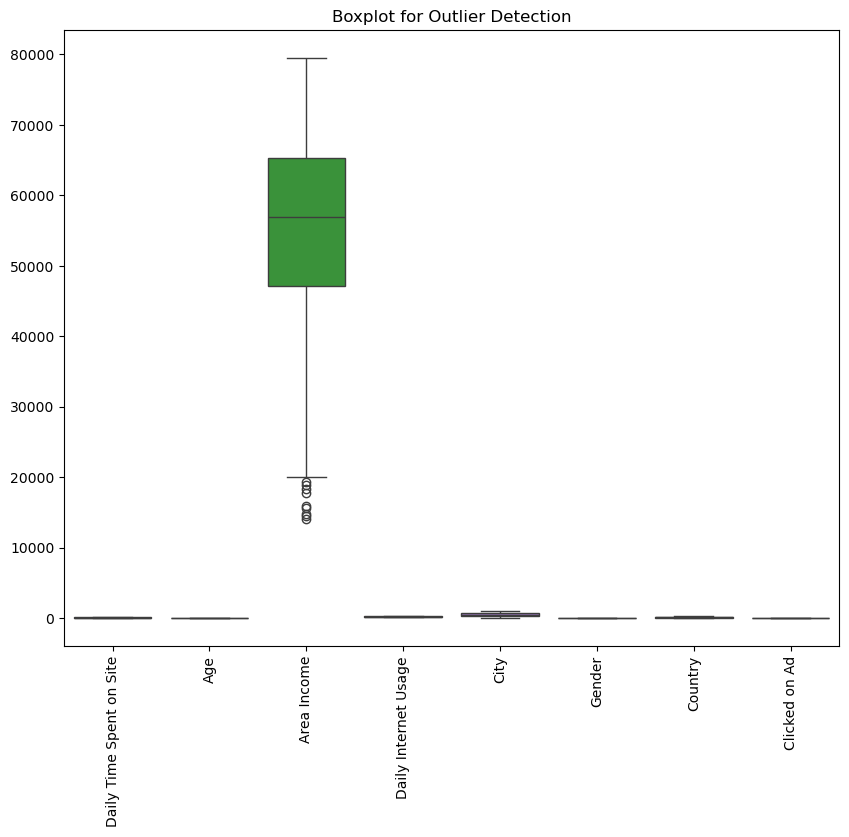

In [33]:
# now outliars..
plt.figure(figsize=(10,8))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title('Boxplot for Outlier Detection')
plt.show()

In [35]:
# Function to cap outliers and count them
def cap_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers before handling
    outliers_before = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    
    # Cap outliers
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

    # Count outliers after handling
    outliers_after = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    
    print(f"Column: {col} | Outliers Before: {outliers_before} | Outliers After: {outliers_after}")

# Apply capping for all numerical columns
for col in num_cols:
    cap_outliers(df, col)

print("Outliers handled successfully!")

Column: Daily Time Spent on Site | Outliers Before: 0 | Outliers After: 0
Column: Age | Outliers Before: 0 | Outliers After: 0
Column: Area Income | Outliers Before: 9 | Outliers After: 0
Column: Daily Internet Usage | Outliers Before: 0 | Outliers After: 0
Column: Clicked on Ad | Outliers Before: 0 | Outliers After: 0
Outliers handled successfully!


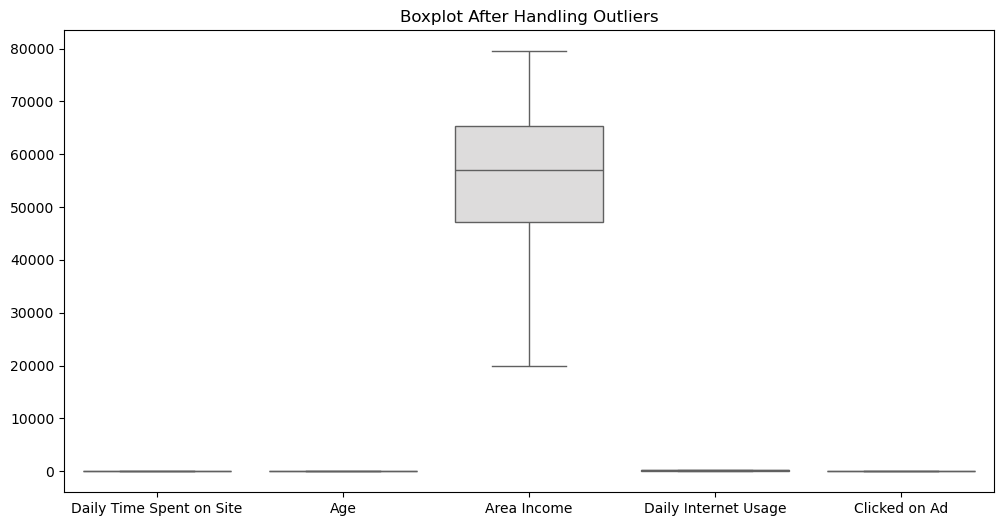

In [37]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[num_cols], palette="coolwarm")
plt.title("Boxplot After Handling Outliers")
plt.show()

In [39]:
# Standardize numerical features
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

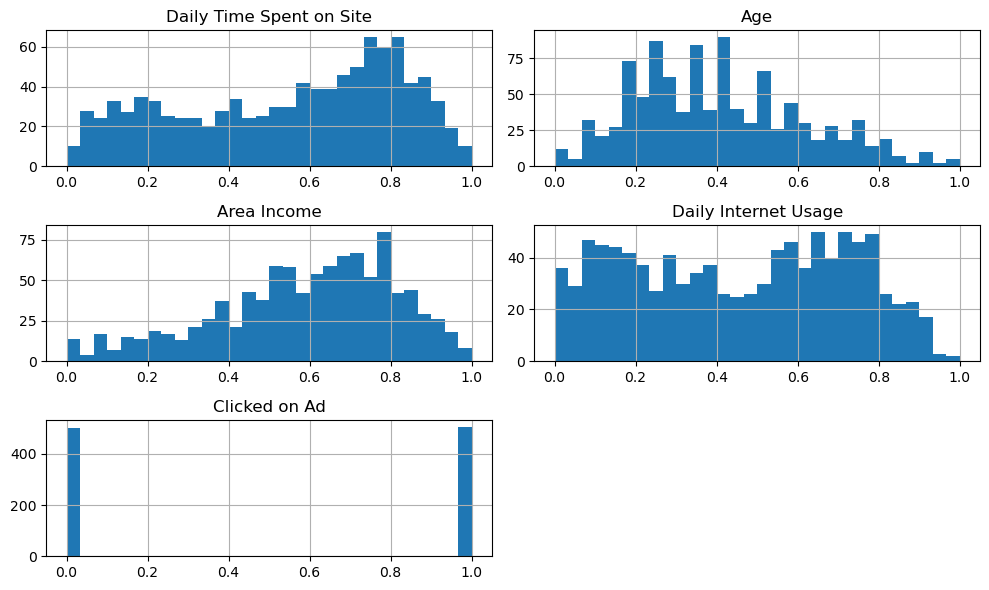

In [41]:
df[num_cols].hist(figsize=(10, 6), bins=30)
plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [43]:
X = df.drop('Clicked on Ad', axis=1)
y = df['Clicked on Ad']

In [45]:
num_cols.remove('Clicked on Ad')

In [49]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [51]:
# Train GaussianNB for numerical columns
gaussian_nb = GaussianNB()
gaussian_nb.fit(X_train[num_cols], y_train)

GaussianNB()

In [55]:
 #Train CategoricalNB for categorical columns
categorical_nb = MultinomialNB()
categorical_nb.fit(X_train[cat_cols], y_train)

MultinomialNB()

In [57]:
# Predict probabilities
num_probs = gaussian_nb.predict_proba(X_test[num_cols])
cat_probs = categorical_nb.predict_proba(X_test[cat_cols])

In [59]:
# Combine predictions by multiplying probabilities
final_probs = num_probs * cat_probs
final_preds = final_probs.argmax(axis=1)

In [63]:
# Evaluate
accuracy = accuracy_score(y_test, final_preds)
accuracy

0.9405940594059405

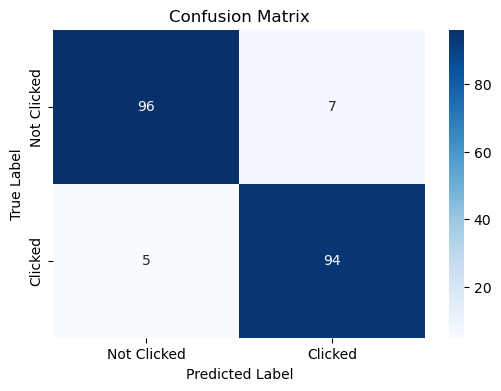

In [67]:
cm = confusion_matrix(y_test,  final_preds)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Clicked', 'Clicked'], yticklabels=['Not Clicked', 'Clicked'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [73]:
 print(classification_report(y_test, final_preds))

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94       103
         1.0       0.93      0.95      0.94        99

    accuracy                           0.94       202
   macro avg       0.94      0.94      0.94       202
weighted avg       0.94      0.94      0.94       202

